In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BASE_PATH = r"C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset"
TRAIN_LBL_DIR = os.path.join(BASE_PATH, "UVH-26-Train", "yolo_labels")
VAL_LBL_DIR = os.path.join(BASE_PATH, "UVH-26-Val", "yolo_labels")

# UPDATED Class List (After Merging)
# IDs 8 and 9 are now placeholders because those objects were moved to IDs 5 and 4.
CLASSES = [
    'Hatchback', 'Sedan', 'SUV', 'MUV', 'Bus', 'Truck', 
    'Three-wheeler', 'Two-wheeler', 'LCV (Merged)', 'Mini-bus (Merged)', 
    'Tempo-traveller', 'Bicycle', 'Van'
]

# Set visual style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
print("Configuration Loaded. Classes set.")

Configuration Loaded. Classes set.


In [2]:
def load_data_with_geometry(root_dir, subset_name):
    """
    Parses YOLO text files to extract Class ID and Bounding Box Geometry.
    """
    data = []
    print(f"Scanning {subset_name} files in {root_dir}...")
    
    txt_files = glob.glob(os.path.join(root_dir, "**", "*.txt"), recursive=True)
    
    for file_path in txt_files:
        if os.path.getsize(file_path) == 0: continue
        
        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    try:
                        cls_id = int(parts[0])
                        x, y, w, h = map(float, parts[1:])
                        
                        # Filter valid classes only
                        if 0 <= cls_id < len(CLASSES):
                            data.append({
                                "subset": subset_name,
                                "class_id": cls_id,
                                "class_name": CLASSES[cls_id],
                                "x_center": x,
                                "y_center": y,
                                "width": w,
                                "height": h,
                                "area": w * h,
                                "aspect_ratio": w / h if h > 0 else 0
                            })
                    except ValueError:
                        continue # Skip bad lines

    print(f"-> Loaded {len(data)} annotations for {subset_name}.")
    return pd.DataFrame(data)

In [3]:
# Load both subsets
df_train = load_data_with_geometry(TRAIN_LBL_DIR, "Train")
df_val = load_data_with_geometry(VAL_LBL_DIR, "Validation")

# Combine
df = pd.concat([df_train, df_val], ignore_index=True)

if df.empty:
    print("Error: No data found. Check your paths.")
else:
    print(f"Total Combined Annotations: {len(df)}")
    display(df.head())

Scanning Train files in C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset\UVH-26-Train\yolo_labels...
-> Loaded 252441 annotations for Train.
Scanning Validation files in C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset\UVH-26-Val\yolo_labels...
-> Loaded 63427 annotations for Validation.
Total Combined Annotations: 315868


,subset,class_id,class_name,x_center,y_center,width,height,area,aspect_ratio
0,Train,7,Two-wheeler,0.133052,0.578472,0.092708,0.190741,0.017683,0.486041
1,Train,6,Three-wheeler,0.205740,0.354046,0.057031,0.088889,0.005069,0.641598
2,Train,5,Truck,0.718453,0.396500,0.044271,0.109259,0.004837,0.405193
3,Train,7,Two-wheeler,0.602823,0.423861,0.025000,0.091667,0.002292,0.272726
4,Train,7,Two-wheeler,0.749646,0.551444,0.070312,0.099074,0.006966,0.709692


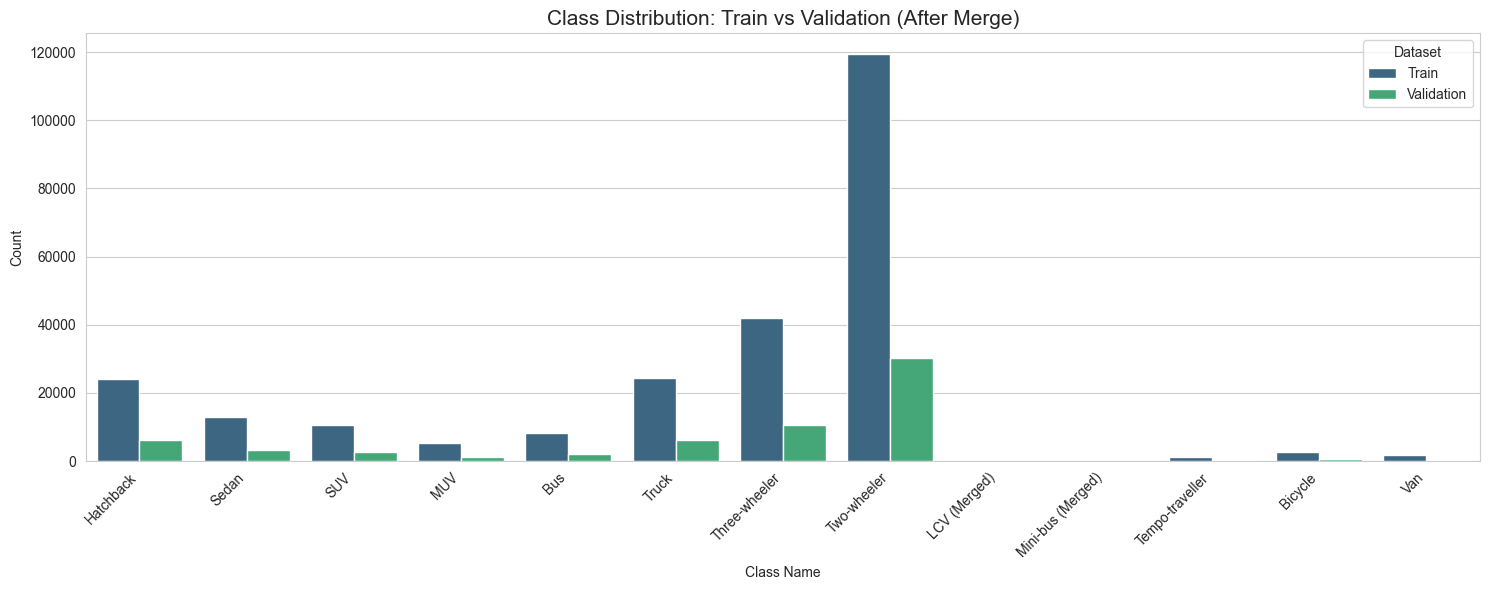

class_name  Bicycle   Bus  Hatchback   MUV    SUV  Sedan  Tempo-traveller  \
subset                                                                      
Train          2710  8155      24196  5208  10536  12799             1345   
Validation      681  2004       6094  1315   2639   3151              335   

class_name  Three-wheeler  Truck  Two-wheeler   Van  
subset                                               
Train               41961  24269       119519  1743  
Validation          10467   6087        30211   443  


In [4]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='class_name', hue='subset', order=CLASSES, palette='viridis')

plt.title("Class Distribution: Train vs Validation (After Merge)", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

# Print exact counts to verify the merge
print(df.groupby(['subset', 'class_name']).size().unstack(fill_value=0))

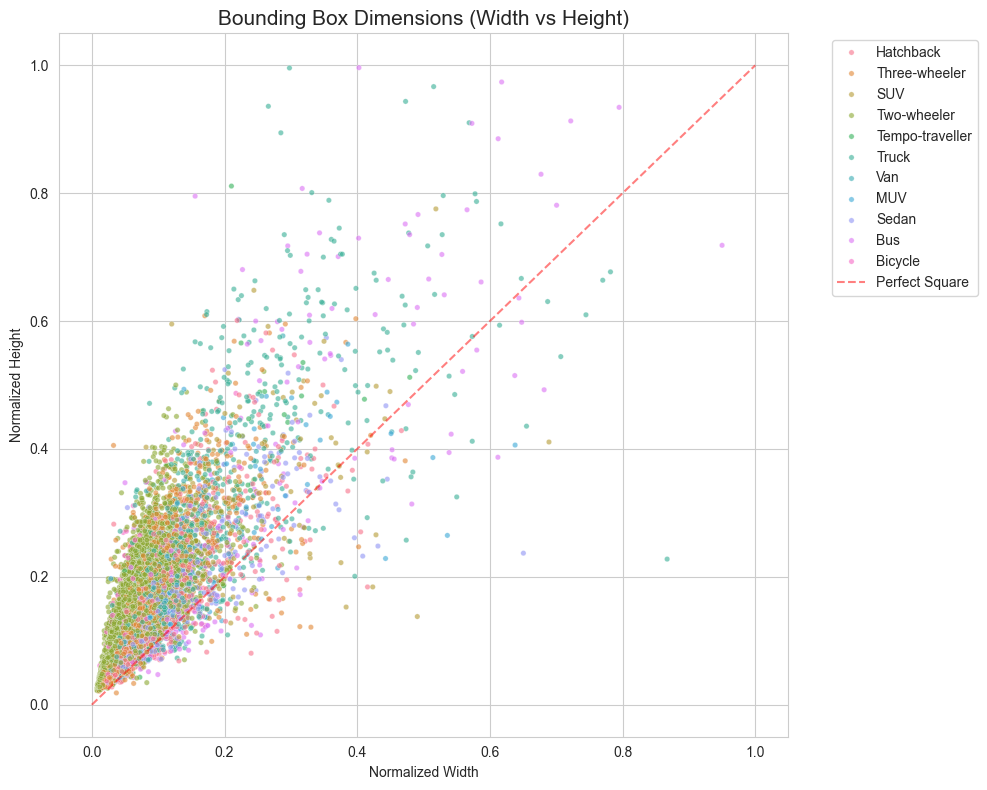

In [5]:
plt.figure(figsize=(10, 8))

# Sample data if it's too large to prevent lag (e.g., max 10k points)
plot_df = df.sample(min(len(df), 10000))

sns.scatterplot(
    data=plot_df, 
    x='width', 
    y='height', 
    hue='class_name', 
    alpha=0.6,
    s=15  # Dot size
)

# Draw a diagonal line (Square boxes)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label="Perfect Square")

plt.title("Bounding Box Dimensions (Width vs Height)", fontsize=15)
plt.xlabel("Normalized Width")
plt.ylabel("Normalized Height")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

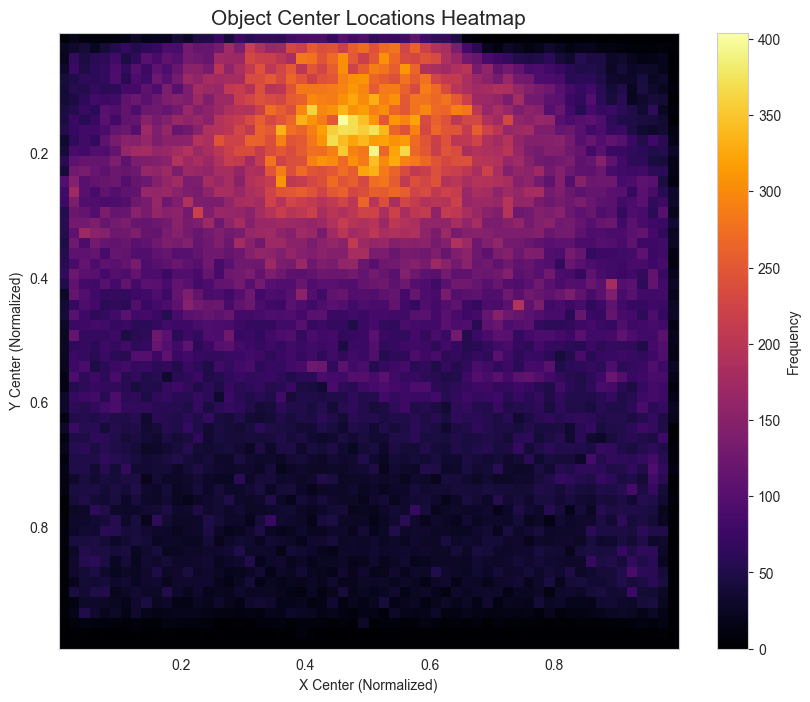

In [6]:
plt.figure(figsize=(10, 8))

plt.hist2d(df['x_center'], df['y_center'], bins=60, cmap='inferno')

plt.colorbar(label='Frequency')
plt.title("Object Center Locations Heatmap", fontsize=15)
plt.xlabel("X Center (Normalized)")
plt.ylabel("Y Center (Normalized)")

# Invert Y axis because images start from top-left (0,0)
plt.gca().invert_yaxis()
plt.show()

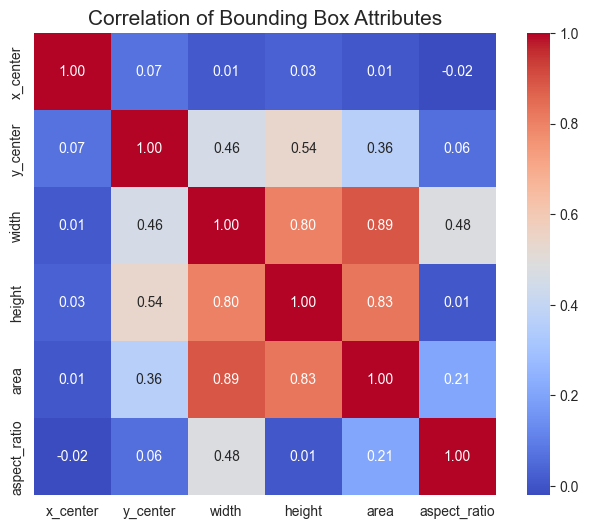

In [7]:
plt.figure(figsize=(8, 6))

corr_cols = ['x_center', 'y_center', 'width', 'height', 'area', 'aspect_ratio']
corr_matrix = df[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title("Correlation of Bounding Box Attributes", fontsize=15)
plt.show()